In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_dir = "../data"

In [ ]:
dfs = [
    (
        "Llama 2 7B 4bit vript",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1819_llama-2-7b_4bit_rephrase_vript.pkl"),
    ),
    (
        "Llama 2 7B 8bit vript",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1908_llama-2-7b_8bit_rephrase_vript.pkl"),
    ),
    (
        "Llama 2 7B 4bit finenews",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1820_llama-2-7b_4bit_rephrase_finenews.pkl"),
    ),
    (
        "Llama 2 7B 8bit finenews",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1909_llama-2-7b_8bit_rephrase_finenews.pkl"),
    ),
    (
        "Llama 2 7B 4bit mlsum",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1912_llama-2-7b_4bit_rephrase_mlsum.pkl"),
    ),
    (
        "Llama 2 7B 4bit commoncorpus",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1911_llama-2-7b_4bit_rephrase_commoncorpus.pkl"),
    ),
]

In [154]:
dfs = [
    (
        "Llama 2 AWQ vript",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2021_llama-awq_rephrase_vript.pkl"),
    ),
    (
        "Llama 2 AWQ finenews",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2032_llama-awq_rephrase_finenews.pkl"),
    ),
    (
        "Llama 2 AWQ commoncorpus",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2067_llama-awq_rephrase_commoncorpus.pkl"),
    ),
    (
        "PolyLM 4bit vript",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2033_polylm-1.7b_4bit_rephrase_vript.pkl"),
    ),
    (
        "PolyLM 4bit commoncorpus",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1981_polylm-1.7b_4bit_rephrase_commoncorpus.pkl"),
    ),
    (
        "PolyLM 4bit finenews",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1982_polylm-1.7b_4bit_rephrase_finenews.pkl"),
    ),
]

In [155]:
# dfs = [(name, df[df["language"] != "en"]) for name, df in dfs]

In [156]:
llama_language_percentages = {
    "en": 0.897,
    "de": 0.0017,
    "es": 0.0013,
    "fr": 0.0016,
    "it": 0.0011,
    "ko": 0.0006,
    "pt": 0.0009,
    "ru": 0.0013,
    "zh": 0.0013,
}

polylm_language_percentages = {
    "en": 0.897,
    "de": 0.0017,
    "es": 0.0089,
    "fr": 0.0081,
    "it": 0.0069,
    "ko": 0.0013,
    "pt": 0.0068,
    "ru": 0.0121,
    "zh": 0.2214,
}

In [157]:
for name, df in dfs:
    if "llama" in name.lower():
        df["language_share"] = df["language"].map(llama_language_percentages)
    elif "polylm" in name.lower():
        df["language_share"] = df["language"].map(polylm_language_percentages)

    df["name"] = name

    df["rephrased_gradient_mean"] = df["rephrased_gradients"].apply(
        lambda x: np.mean(x)
    )

    df["total_gradient"] = df["prompt_gradient"] + df["rephrased_gradient_mean"]

    df["total_gradient_std"] = df.apply(
        lambda x: np.std(x["rephrased_gradients"] + [x["prompt_gradient"]]), axis=1
    )

df_all = pd.concat([df for _, df in dfs])
dfs.append(("all", df_all))

In [162]:
show_legend = False
log_x_axis = False
log_y_axis = False

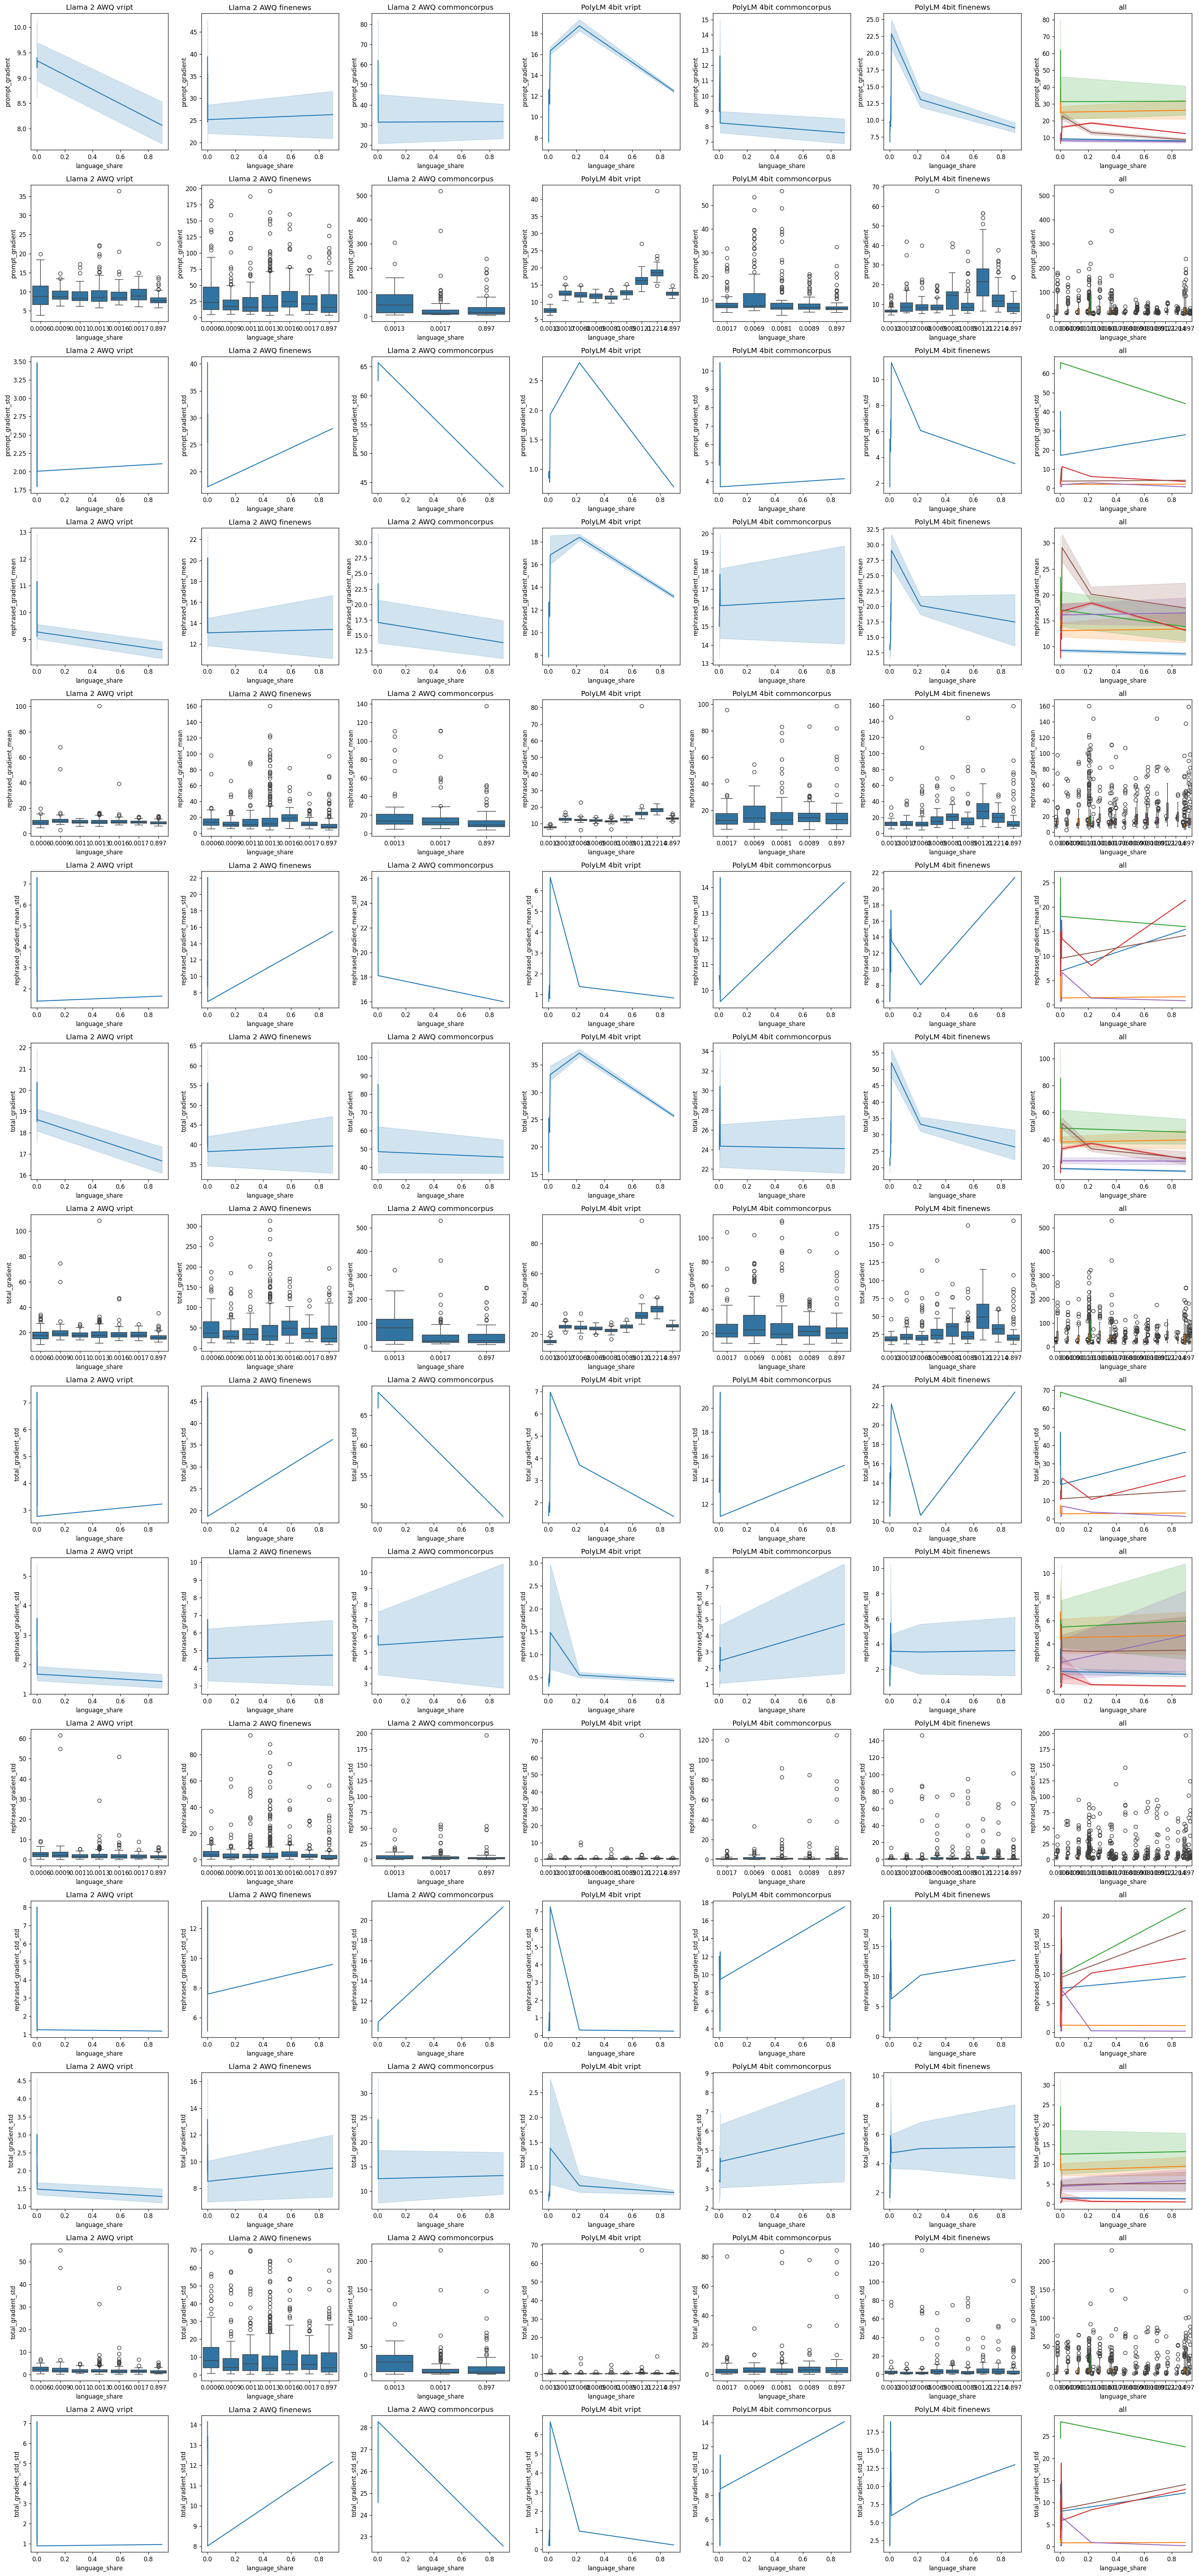

In [163]:
plt.rcParams["figure.dpi"] = 120
plot_size = 4

plt_width = len(dfs)
plt_height = 15

fig, axs = plt.subplots(
    plt_height,
    plt_width,
    figsize=(plt_width * plot_size, plt_height * plot_size),
    squeeze=False,
)

for i, (name, df) in enumerate(dfs):
    legend = False if name != "all" else show_legend

    std_by_language_share = df.groupby(["language_share", "name"]).agg(
        prompt_gradient_std=("prompt_gradient", "std"),
        rephrased_gradient_mean_std=("rephrased_gradient_mean", "std"),
        rephrased_gradient_std_std=("rephrased_gradient_std", "std"),
        total_gradient_std=("total_gradient", "std"),
        total_gradient_std_std=("total_gradient_std", "std"),
    ).reset_index()

    j = 0

    # sns.boxplot(data=df, x="language", y="prompt_gradient", ax=axs[j][i])
    # j += 1

    sns.lineplot(
        data=df,
        x="language_share",
        y="prompt_gradient",
        ax=axs[j][i],
        legend=legend,
        hue="name",
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    sns.boxplot(
        data=df,
        x="language_share",
        y="prompt_gradient",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    j += 1

    sns.lineplot(
        data=std_by_language_share,
        x="language_share",
        y="prompt_gradient_std",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    # sns.boxplot(data=df, x="language", y="rephrased_gradient_mean", ax=axs[j][i])
    # j += 1

    sns.lineplot(
        data=df,
        x="language_share",
        y="rephrased_gradient_mean",
        ax=axs[j][i],
        legend=legend,
        hue="name",
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    sns.boxplot(
        data=df,
        x="language_share",
        y="rephrased_gradient_mean",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    j += 1

    sns.lineplot(
        data=std_by_language_share,
        x="language_share",
        y="rephrased_gradient_mean_std",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    sns.lineplot(
        data=df,
        x="language_share",
        y="total_gradient",
        ax=axs[j][i],
        legend=legend,
        hue="name",
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    sns.boxplot(
        data=df,
        x="language_share",
        y="total_gradient",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    j += 1

    sns.lineplot(
        data=std_by_language_share,
        x="language_share",
        y="total_gradient_std",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    # sns.boxplot(data=df, x="language", y="rephrased_gradient_std", ax=axs[j][i])
    # j += 1

    sns.lineplot(
        data=df,
        x="language_share",
        y="rephrased_gradient_std",
        ax=axs[j][i],
        legend=legend,
        hue="name",
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    sns.boxplot(
        data=df,
        x="language_share",
        y="rephrased_gradient_std",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    j += 1

    sns.lineplot(
        data=std_by_language_share,
        x="language_share",
        y="rephrased_gradient_std_std",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    sns.lineplot(
        data=df,
        x="language_share",
        y="total_gradient_std",
        ax=axs[j][i],
        legend=legend,
        hue="name",
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    sns.boxplot(
        data=df,
        x="language_share",
        y="total_gradient_std",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    j += 1

    sns.lineplot(
        data=std_by_language_share,
        x="language_share",
        y="total_gradient_std_std",
        ax=axs[j][i],
        hue="name",
        legend=legend,
    )
    if log_x_axis:
        axs[j][i].set(xscale="log")
    if log_y_axis:
        axs[j][i].set(yscale="log")
    j += 1

    for ax in axs.T[i]:
        ax.set_title(name)


plt.tight_layout()